# Datathon Mayo 2018  **_"Haciendo el gasto fiscal visible para el público"_**
## Gasto Neto Mensualizado por año de las Instituciones Públicas

## Lectura de Datos

In [39]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import pandas_profiling as pd_profiling
import altair as alt

In [40]:
def read_field_type(x):
    '''
    Para facilitar la lectura de los dataframes con los tipos de columna correspondientes.
    '''
    if x in ['String']:
        return str
    elif x in ['Integer', 'Long']:
        return int
    else:
        return str

In [41]:
pub_spend_names = pd.read_csv(os.path.join('data', 
                              'dataset_1_monthly_spend_2009-2017_DICTIONARY.csv'), 
                              sep=';', 
                              encoding='utf-8')

In [42]:
pub_spend_names

,Field name,Field type,Field size,Field format,Range,Description,Example
0,Periodo,Integer,15,#,2009 to 2017,Year of the spend,2009
1,Nombre Partida,String,63,NaN,28 categories,Ministeries,Ministerio de Educación
2,Nombre Capitulo,String,78,NaN,219 categories,Public Services,Fondo Nacional de Salud
3,Nombre Programa,String,78,NaN,363 categories,Programs,Fondo Nacional de Salud
4,Nombre Subtitulo,String,37,NaN,10 categories,First level of the budget classification,TRANSFERENCIAS CORRIENTES
5,Nombre Item,String,54,NaN,43 categories,Second level of the budget classification,Al Sector Privado
6,Nombre Asignación,String,250,NaN,4372 categories,Third level of the budget classification,Subsidios Fondo Solidario de Vivienda
7,Nombre SubAsignación,String,80,NaN,1355 categories,Last level of the budget classification,Asistencia Técnica
8,Mes,String,10,NaN,12 categories,Month,enero
9,Monto,Integer,15,#,(-49702217) to 357607483,"Amount, this data was update by the inflation ...",357607483


In [62]:
pub_spend = pd.read_csv(os.path.join('data', 
                              'dataset_1_monthly_spend_2009-2017.csv'),
                 sep=';', 
                 encoding='utf-8',
                 dtype=dict(zip(pub_spend_names['Field name'], pub_spend_names['Field type'].apply(read_field_type))))

In [63]:
pub_spend.head(5) 

,Periodo,Nombre Partida,Nombre Capitulo,Nombre Programa,Nombre Subtitulo,Nombre Item,Nombre Asignación,Nombre SubAsignación,Mes,Monto_sum
0,2009,Congreso Nacional,Biblioteca Del Congreso,Biblioteca Del Congreso,INICIATIVAS DE INVERSIÓN,Proyectos,Gastos Administrativos,NaN,Abril,0
1,2009,Congreso Nacional,Biblioteca Del Congreso,Biblioteca Del Congreso,INICIATIVAS DE INVERSIÓN,Proyectos,Gastos Administrativos,NaN,Agosto,0
2,2009,Congreso Nacional,Biblioteca Del Congreso,Biblioteca Del Congreso,INICIATIVAS DE INVERSIÓN,Proyectos,Gastos Administrativos,NaN,Diciembre,0
3,2009,Congreso Nacional,Biblioteca Del Congreso,Biblioteca Del Congreso,INICIATIVAS DE INVERSIÓN,Proyectos,Gastos Administrativos,NaN,Enero,0
4,2009,Congreso Nacional,Biblioteca Del Congreso,Biblioteca Del Congreso,INICIATIVAS DE INVERSIÓN,Proyectos,Gastos Administrativos,NaN,Febrero,0


In [64]:
pub_spend.columns = ['periodo', 'partida', 'capitulo', 'programa', 'subtitulo', 'item', 'asignacion', 'subasignacion', 'mes', 'gasto']

In [65]:
pub_spend.shape

(3110448, 10)

In [66]:
pub_spend = pub_spend[pub_spend['gasto'] != 0]

# Estadística descriptiva

In [68]:
alt.data_transformers.enable('json')
# alt.data_transformers.enable('default', max_rows=10000)

DataTransformerRegistry.enable('json')

## Gasto anual

In [69]:
# pub_spend_annual = pub_spend.groupby(['periodo', 'mes', 'partida'], as_index=False)['gasto'].sum()

In [76]:
# pub_spend_annual_chart = alt.Chart(pub_spend_annual).mark_line().encode(
#     x='periodo:O',
#     y='sum(gasto)',
# ).properties( 
#     width=600, 
#     height=400 
# )

# pub_spend_annual_chart

In [70]:
es_month_dict = {'enero': 1,
                 'febrero': 2,
                 'marzo': 3, 
                 'abril': 4,
                 'mayo': 5,
                 'junio': 6,
                 'julio': 7,
                 'agosto': 8,
                 'septiembre': 9,
                 'octubre': 10,
                 'noviembre': 11,
                 'diciembre': 12
                }

In [71]:
pub_spend['nm_month'] = pub_spend['mes'].str.lower().map(es_month_dict)
pub_spend['year_month'] = pub_spend['periodo'].astype(str) + '-' + pub_spend['nm_month'].astype(str)

In [72]:
pub_spend_chart = alt.Chart(pub_spend).mark_line().encode(
    x='periodo:O',
    y='sum(gasto)',
).properties( 
    width=600, 
    height=400 
)

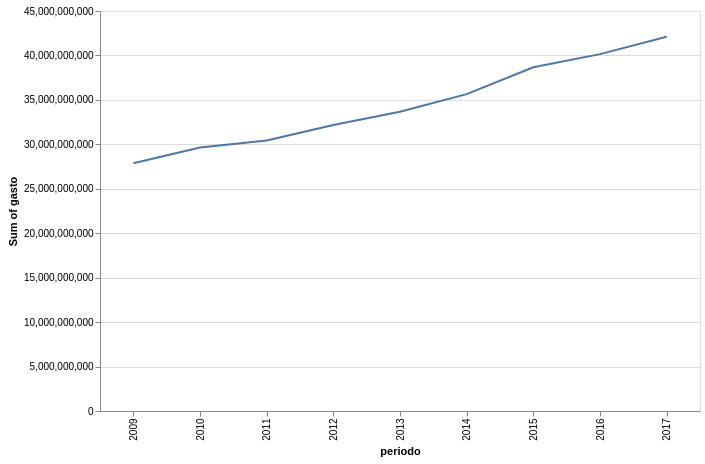

In [73]:
pub_spend_chart

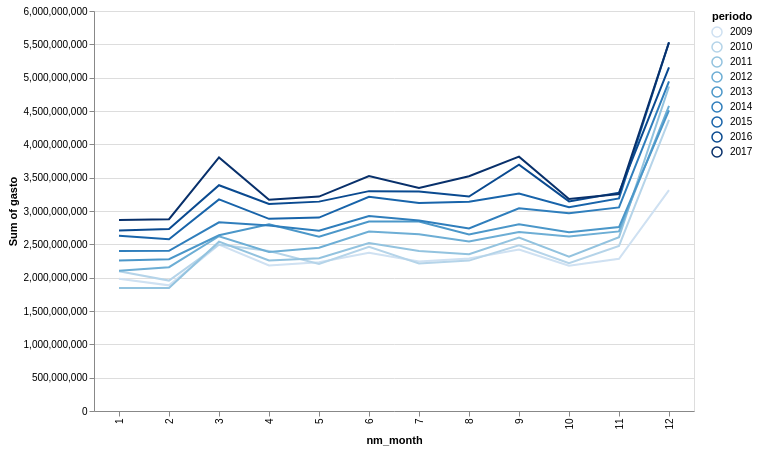

In [75]:
pub_spend_chart.encode(x='nm_month:O', color='periodo:O')

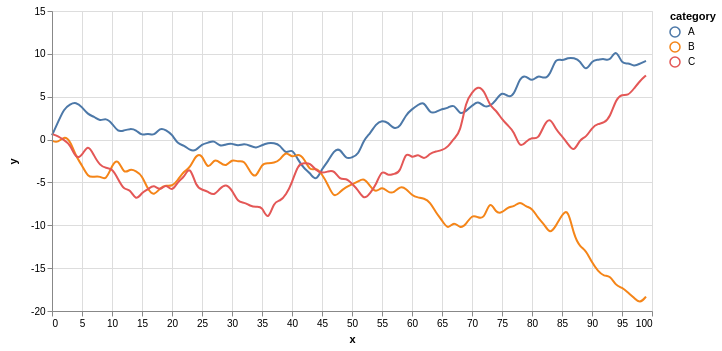

In [77]:
np.random.seed(42)
data = pd.DataFrame(np.cumsum(np.random.randn(100, 3), 0).round(2),
                    columns=['A', 'B', 'C'], index=pd.RangeIndex(100, name='x'))
data = data.reset_index().melt('x', var_name='category', value_name='y')

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['x'], empty='none')

# The basic line
line = alt.Chart().mark_line(interpolate='basis').encode(
    x='x:Q',
    y='y:Q',
    color='category:N'
)

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart().mark_point().encode(
    x='x:Q',
    opacity=alt.value(0),
).properties(
    selection=nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'y:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart().mark_rule(color='gray').encode(
    x='x:Q',
).transform_filter(
    nearest.ref()
)

# Put the five layers into a chart and bind the data
alt.layer(line, selectors, points, rules, text,
          data=data, width=600, height=300)

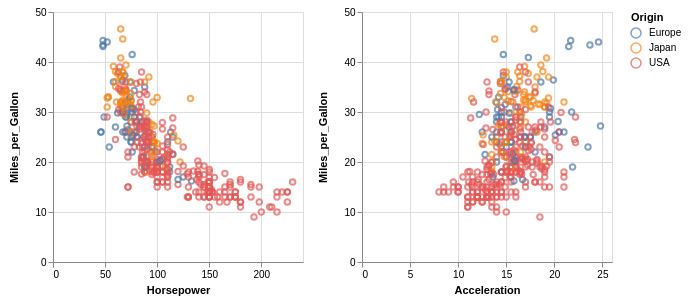

In [78]:
from vega_datasets import data

cars = data.cars()

brush = alt.selection(type='interval', resolve='global')

base = alt.Chart(cars).mark_point().encode(
    y='Miles_per_Gallon',
    color=alt.condition(brush, 'Origin', alt.ColorValue('gray'))
).properties(
    selection=brush,
    width=250,
    height=250
)

base.encode(x='Horsepower') | base.encode(x='Acceleration')

## Gasto por Año-Mes

In [ ]:
pub_spend_annual['nm_month'] = pub_spend_annual['mes'].str.lower().map(es_month_dict)
pub_spend_annual['nm_day'] = 15
pub_spend_annual['year_month'] = pd.to_datetime(pub_spend_annual[['periodo', 'nm_month', 'nm_day']].apply(lambda row: '/'.join(row.astype(str)), axis=1))

In [ ]:
alt.Chart(pub_spend_annual).mark_line().encode(
    x=alt.X('year_month:T', 
            timeUnit='yearmonth',
            axis=alt.Axis( title='Year-Month')
           ),
    y='sum(gasto)',
).properties( 
    width=600, 
    height=400 
)

In [ ]:
alt.Chart(pub_spend_annual).mark_line().encode(
    alt.X(
        'year_month:T', timeUnit='monthdate',
        axis=alt.Axis(format='%B', title='Month')
    ),
    alt.Y(
        'sum(gasto):Q', stack=None,
        axis=alt.Axis(title='Total Spend')
    ),
    alt.Color('year_month:N', timeUnit='year', legend=alt.Legend(title='Year')),
    alt.Order('year_month:O', timeUnit='year')
).properties( 
    width=1200, 
    height=500,
)

In [ ]:
alt.Chart(pub_spend_annual).mark_bar().encode(
    x='sum(gasto):Q',
    y='periodo:O',
    color=alt.Color('year_month:O', timeUnit='month', legend=alt.Legend(title='Month'), sort='ascending')
).properties( 
    width=700, 
    height=400 
)